In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import copy
%matplotlib notebook

In [2]:
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition
from neurodiffeq.networks import FCNN    # fully-connect neural network
from neurodiffeq.networks import SinActv # sin activation
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.solvers import Solver1D
from neurodiffeq.callbacks import MonitorCallback
from neurodiffeq.callbacks import WeightCallback
from neurodiffeq.callbacks import WeightCallback1,WeightCallback2
from neurodiffeq.callbacks import PeriodLocal
import copy

/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
MAX_EPOCHS = 3000
BURNIN = 0
SUB_RATE = 1

mdl_weight_collector = []


DIFFEQS_TRAIN = {
'exp':lambda u,t: [diff(u, t) + u],
'exp1':lambda u,t: [diff(u, t) - u],
'tanh': lambda u,t:[diff(u, t) + u**2 -1],
'psig':lambda u,t: [diff(u, t) -3*u +u**2],
'r1': lambda u,t:[diff(u, t) -u +u**2 +u**3],
'r2': lambda u,t:[diff(u, t) +u +u**2],
'r3': lambda u,t:[diff(u, t) +u**2],
'r4': lambda u,t:[diff(u, t) -u**2],
'sigmoid': lambda u,t:[diff(u, t) -u + u**2],
# 'sigmoid1': lambda u,t:[diff(u, t) -u +u**2],
'q2': lambda u,t:[diff(u, t) -u +u**2-u**3],
'q3': lambda u,t:[diff(u, t)  +u**2+u**4],
'q4': lambda u,t:[diff(u, t)  -u**2-u**4],
'high_order': lambda u,t:[diff(u, t) +u -u**2+u**3-u**4+u**5],
}

SOLUTIONS_TRAIN = {}
MODEL_TRAIN = {}

SOLUTIONS_TEST = {}
MODEL_TEST = {}

INIT_VAL = [IVP(t_0=0.0, u_0=0.5)]
T_MIN = 0
T_MAX = 2
ts = torch.linspace(T_MIN,T_MAX,100)

for system_name,system in DIFFEQS_TRAIN.items():
    solver = Solver1D(
        ode_system=system,
        conditions=INIT_VAL,
        t_min=T_MIN,
        t_max=T_MAX
    )
    solver.fit(max_epochs=MAX_EPOCHS)
    solution = solver.get_solution(best=False)(ts,to_numpy=True)
    SOLUTIONS_TRAIN[system_name]=solution
    MODEL_TRAIN[system_name]=copy.deepcopy(solver.nets[0])

In [4]:
DIFFEQS_TEST = {
'q1': lambda u,t:[diff(u, t) -u +u**2],
'q2': lambda u,t:[diff(u, t) -u +u**2-u**3],
'q3': lambda u,t:[diff(u, t)  +u**2+u**4],
'q4': lambda u,t:[diff(u, t)  -u**2-u**4],
}


for system_name,system in DIFFEQS_TEST.items():
    solver = Solver1D( 
            ode_system= system,
            conditions=INIT_VAL,
            t_min=T_MIN,
            t_max=T_MAX
        )
    solver.fit(max_epochs=500)
    solution = solver.get_solution(best=False)(ts,to_numpy=True)
    SOLUTIONS_TEST[system_name]=solution
    MODEL_TEST[system_name]=copy.deepcopy(solver.nets[0])

In [5]:
SOLUTIONS_GT_TEST = {}
for system_name,system in DIFFEQS_TEST.items():
    solver = Solver1D( 
            ode_system= system,
            conditions=INIT_VAL,
            t_min=T_MIN,
            t_max=T_MAX
        )
    solver.fit(max_epochs=3000)
    solution = solver.get_solution(best=False)(ts,to_numpy=True)
    SOLUTIONS_GT_TEST[system_name]=copy.deepcopy(solution)
#     MODEL_TEST[system_name]=solver.nets[0]

In [6]:
PRE_MAX_EPOCHS=10
PRETRAINED_SOLUTIONS = {}
for system_name,system in DIFFEQS_TRAIN.items():
    for system_name_test,system_test in DIFFEQS_TEST.items():
        solver = Solver1D(
            ode_system=system_test,
            conditions=INIT_VAL,
            t_min=T_MIN,
            t_max=T_MAX,
            nets=[copy.deepcopy(MODEL_TRAIN[system_name])]
        )
        solver.fit(max_epochs=PRE_MAX_EPOCHS)
        solution = solver.get_solution(best=False)(ts,to_numpy=True)
        PRETRAINED_SOLUTIONS[f'{system_name_test}_{system_name}']=solution

In [7]:
errors_pre_gt = np.zeros((len(DIFFEQS_TEST),len(DIFFEQS_TRAIN)))
errors_train_test = np.zeros((len(DIFFEQS_TEST),len(DIFFEQS_TRAIN)))
for j,(system_name,system) in enumerate(DIFFEQS_TRAIN.items()):
    for i,(system_name_test,system_test) in enumerate(DIFFEQS_TEST.items()):
        errors_pre_gt[i,j]=((PRETRAINED_SOLUTIONS[f'{system_name_test}_{system_name}'] - SOLUTIONS_GT_TEST[system_name_test])**2).mean()
        errors_train_test[i,j]=((SOLUTIONS_TEST[system_name_test] - SOLUTIONS_TRAIN[system_name])**2).mean()

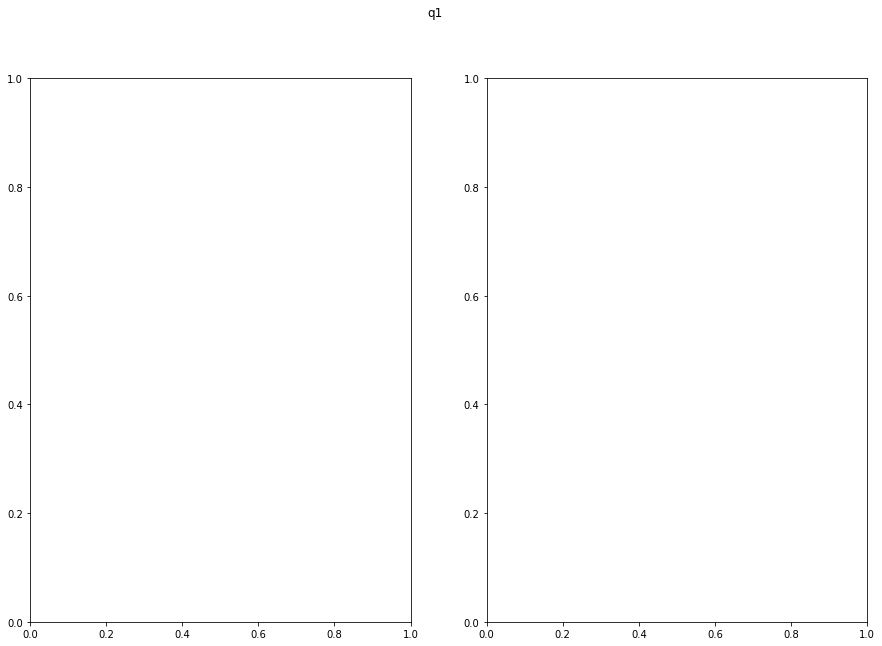

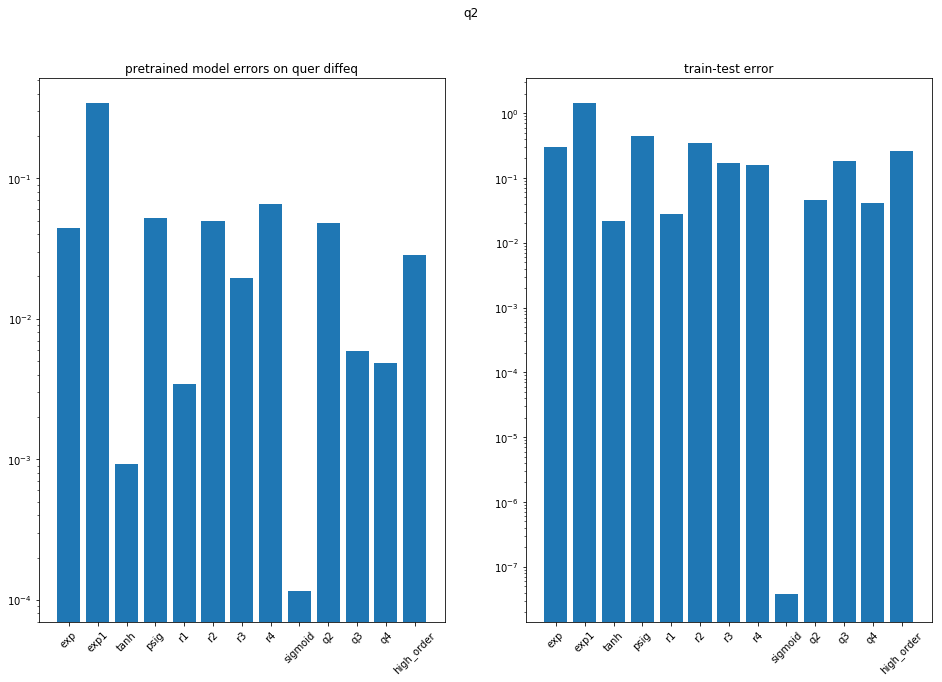

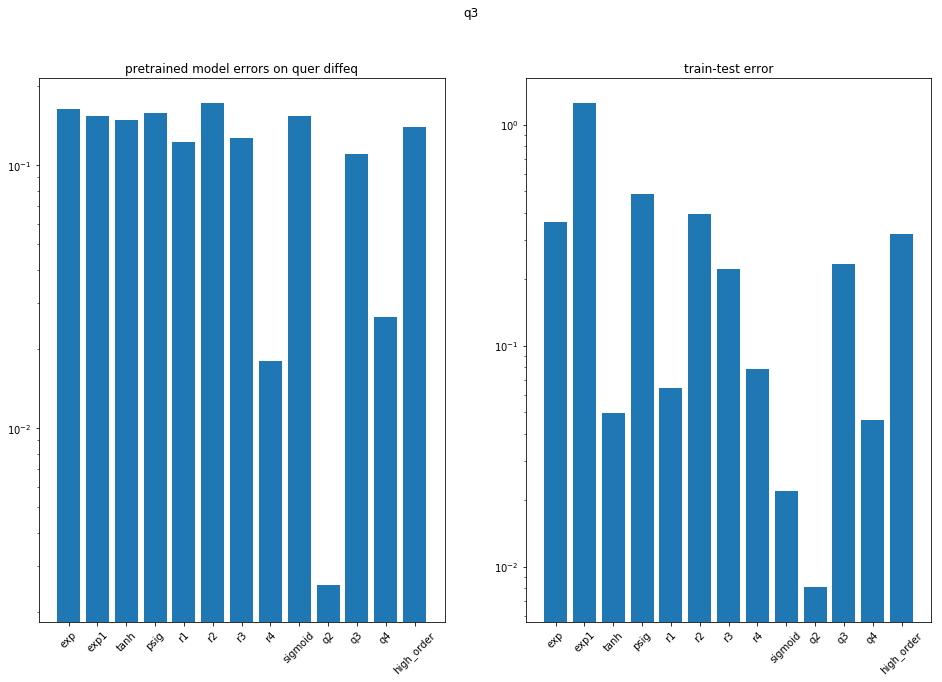

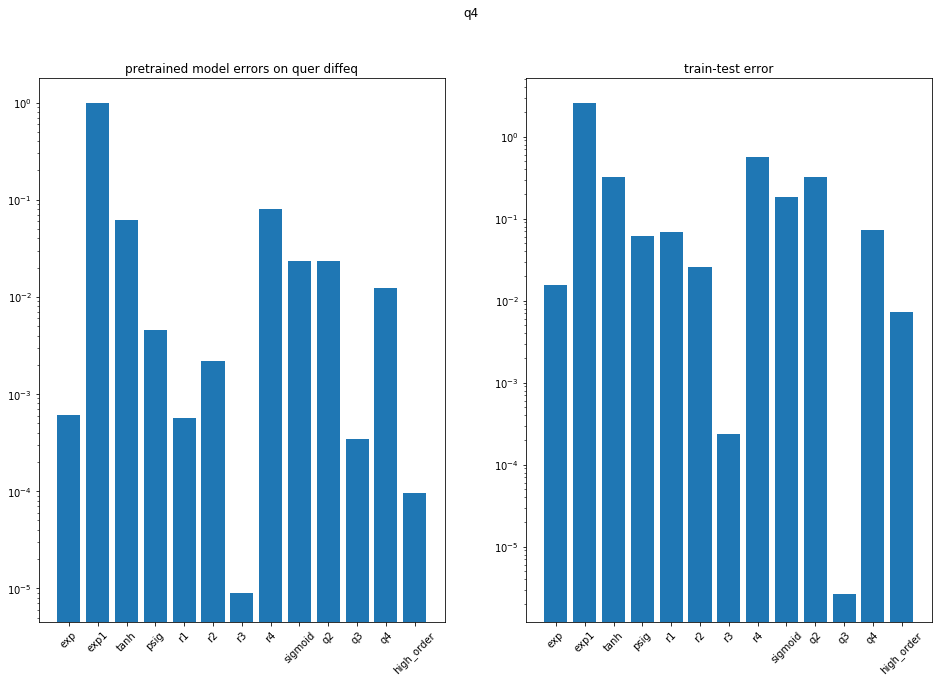

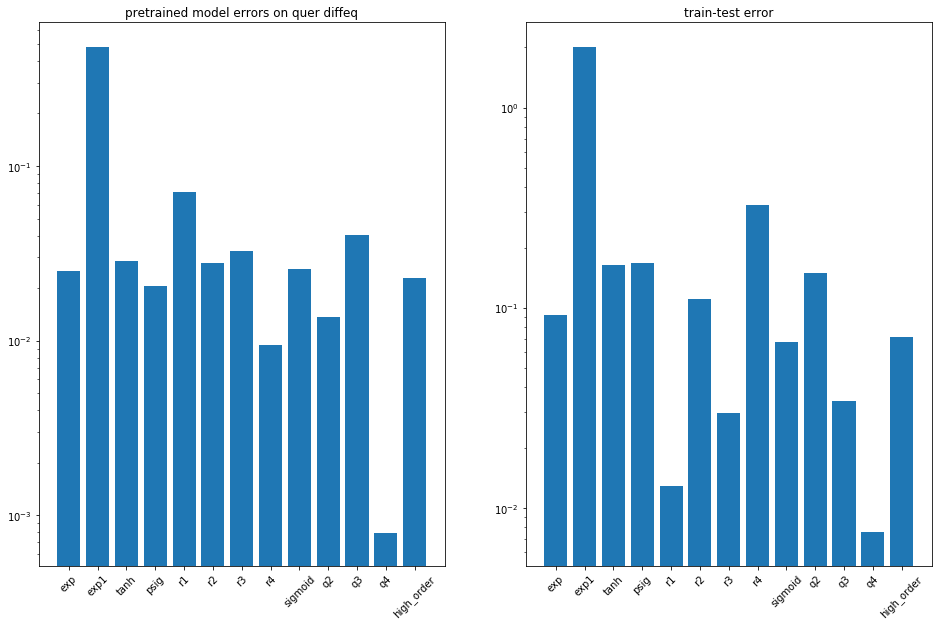

In [9]:
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(15,10))
for i in range(len(DIFFEQS_TEST.keys())):
    fig.suptitle(list(DIFFEQS_TEST.keys())[i])
    fig,ax = plt.subplots(1,2,figsize=(16,10))
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)

    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[0].bar(DIFFEQS_TRAIN.keys(),errors_pre_gt[i,:])
    ax[1].bar(DIFFEQS_TRAIN.keys(),errors_train_test[i,:])
    ax[0].set_title('pretrained model errors on quer diffeq')
    ax[1].set_title('train-test error')


In [ ]:
%matplotlib inline

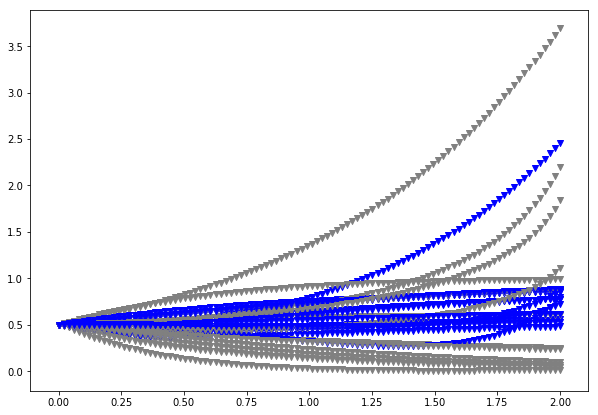

In [20]:
test_name = 'q1'
plt.figure(figsize=(10,7))
for system_name,system in DIFFEQS_TRAIN.items():
    solution = SOLUTIONS_TRAIN[system_name]
    plt.scatter(np.linspace(T_MIN,T_MAX,100),solution,marker='v',color='grey')
    
    
    solution = PRETRAINED_SOLUTIONS[f'{test_name}_{system_name}']
    plt.scatter(np.linspace(T_MIN,T_MAX,100),solution,marker='v',color='blue')

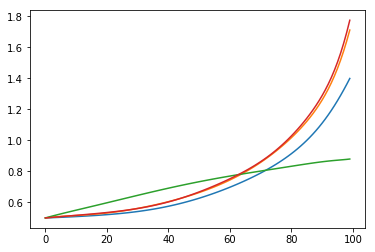

In [20]:
plt.figure()
plt.plot(SOLUTIONS_TEST['q2'])

plt.plot(SOLUTIONS_GT_TEST['q2'])
plt.plot(PRETRAINED_SOLUTIONS['q1_q2'])
plt.plot(PRETRAINED_SOLUTIONS['q2_r4'])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity(PRETRAINED_SOLUTIONS[f'{system_name_test}_{system_name}'].reshape(1,-1))

In [ ]:
errors_pre_gt = np.zeros((len(DIFFEQS_TEST),len(DIFFEQS_TRAIN)))
errors_train_test = np.zeros((len(DIFFEQS_TEST),len(DIFFEQS_TRAIN)))
for j,(system_name,system) in enumerate(DIFFEQS_TRAIN.items()):
    for i,(system_name_test,system_test) in enumerate(DIFFEQS_TEST.items()):
        errors_pre_gt[i,j]=cosine_similarity(PRETRAINED_SOLUTIONS[f'{system_name_test}_{system_name}'].reshape(1,-1),SOLUTIONS_GT_TEST[system_name_test].reshape(1,-1))
        errors_train_test[i,j]=cosine_similarity(SOLUTIONS_TEST[system_name_test].reshape(1,-1),SOLUTIONS_TRAIN[system_name].reshape(1,-1))
        
        
        
        

In [ ]:
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(15,10))
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].bar(DIFFEQS_TRAIN.keys(),errors_pre_gt[1,:])
ax[1].bar(DIFFEQS_TRAIN.keys(),errors_train_test[1,:])
ax[0].set_title('pretrained model errors on query diffeq')
ax[1].set_title('train-test error')

In [ ]:
errors_pre_gt = np.zeros((len(DIFFEQS_TEST),len(DIFFEQS_TRAIN)))
errors_train_test = np.zeros((len(DIFFEQS_TEST),len(DIFFEQS_TRAIN)))
for j,(system_name,system) in enumerate(DIFFEQS_TRAIN.items()):
    for i,(system_name_test,system_test) in enumerate(DIFFEQS_TEST.items()):
        errors_pre_gt[i,j]=np.linalg.norm(PRETRAINED_SOLUTIONS[f'{system_name_test}_{system_name}'].reshape(1,-1)-SOLUTIONS_GT_TEST[system_name_test].reshape(1,-1),ord=1)
        errors_train_test[i,j]=np.linalg.norm(SOLUTIONS_TEST[system_name_test].reshape(1,-1)-SOLUTIONS_TRAIN[system_name].reshape(1,-1),ord=1)
        
        
        
        

In [ ]:
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(15,10))
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].bar(DIFFEQS_TRAIN.keys(),errors_pre_gt[1,:])
ax[1].bar(DIFFEQS_TRAIN.keys(),errors_train_test[1,:])
ax[0].set_title('pretrained model errors on query diffeq')
ax[1].set_title('train-test error')

In [ ]:
plt.figure()
plt.plot(SOLUTIONS_GT_TEST['q2'])
plt.plot(SOLUTIONS_TEST['q2'],marker='x')
plt.plot(SOLUTIONS_TRAIN['sigmoid'],marker='v')

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(SOLUTIONS_GT_TEST['q1'])
plt.plot(SOLUTIONS_TEST['q1'],marker='x')
# plt.plot(SOLUTIONS_TEST['q1'],marker='x')
plt.plot(PRETRAINED_SOLUTIONS['q1_sigmoid'],marker='v')

In [ ]:
gt_sigmoid = torch.sigmoid(torch.linspace(0,2,100)).detach().numpy()

In [ ]:
MSE(gt_sigmoid,SOLUTIONS_GT_TEST['q1'])

In [ ]:
MSE(gt_sigmoid,SOLUTIONS_TEST['q1'])

In [ ]:
MSE(gt_sigmoid,PRETRAINED_SOLUTIONS['q1_sigmoid'])

In [ ]:
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
import copy

In [25]:
INIT_VAL = [IVP(t_0=0.0, u_0=0.5)]
T_MIN = 0
T_MAX = 2
MAX_EPOCHS=3000

solver = Solver1D(
    ode_system=lambda u,t: [diff(u, t) - u+u**2],
    conditions=INIT_VAL,
    t_min=T_MIN,
    t_max=T_MAX
)
solver.fit(max_epochs=MAX_EPOCHS)
solution1 = solver.get_solution()(ts,to_numpy=True)

#deepcopy the weights to trial
trial = copy.deepcopy(solver.get_internals()['nets'][0])
#set bestn to solvers best weights
bestn = solver.get_internals()['nets'][0]


solver2 = Solver1D(
    ode_system=lambda u,t: [diff(u, t) - u+u**2],
    conditions=INIT_VAL,
    t_min=T_MIN,
    t_max=T_MAX,
    nets = [bestn]
)
solver2.fit(max_epochs=200)
solution2 = solver2.get_solution()(ts,to_numpy=True)

for param in bestn.parameters():
    for param_b in trial.parameters():
#         print(param,param_b)
        print(param==param_b)

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ...,

In [ ]:
MSE(gt_sigmoid,solution1),MSE(gt_sigmoid,solution2)

In [ ]:
# main_keys=list(DIFFEQ_SOLUTIONS.keys())
# ERRORS = np.zeros((len(main_keys),len(main_keys)))
# PRE_ERRORS = np.zeros((len(main_keys),len(main_keys)))

# for i,key_a in enumerate(main_keys):
#     for j,key_b in enumerate(main_keys):
#         DIFFEQ_SOLUTIONS[key_a]
#         DIFFEQ_SOLUTIONS[key_b]
#         ERRORS[i,j] = ((DIFFEQ_SOLUTIONS[key_a]-DIFFEQ_SOLUTIONS[key_b])**2).mean()
#         PRE_ERRORS[i,j] = ((PRETRAINED_SOLUTIONS[key_a]-PRETRAINED_SOLUTIONS[key_b])**2).mean()

# ERRORS[ERRORS==0] = 10
# PRE_ERRORS[PRE_ERRORS==0] = 10

In [ ]:
# from matplotlib import ticker, cm
# from matplotlib.colors import LogNorm
# import seaborn as sns
# %matplotlib inline
# plt.figure(figsize=(15,10))
# sns.heatmap(ERRORS, norm=LogNorm())
# # plt.imshow(ERRORS, cmap='viridis')
# # plt.colorbar()
# # plt.zscale('log')
# # plt.show()